# State Farm Distracted Driver - Competition

## 1. Preprocessing

In [37]:
current_path = %pwd

In [2]:
!mkdir -p data data/statefarm data/statefarm/orig_data  data/statefarm/test/ data/statefarm/validate data/statefarm/sample data/statefarm/sample/train data/statefarm/sample/validate
!kg config -g -c state-farm-distracted-driver-detection
%cd data/statefarm/orig_data

/home/sai/Desktop/fast-ai/deeplearning1/nbs/data/statefarm/orig_data


In [69]:
#!kg download
!unzip '*.zip'

In [3]:
!mv train ../train
!mv test ../test/unknown

In [4]:
%cd $current_path

/home/sai/Desktop/fast-ai/deeplearning/notebooks


In [5]:
lookup = 'data/statefarm/orig_data/driver_imgs_list.csv'

In [6]:
path = 'data/statefarm/'
train_path = path + 'train/'
val_path = path + 'validate/'

In [7]:
import pandas as pd
import random
import shutil
import os
from __future__ import print_function

In [10]:
drivers = pd.read_csv(lookup)
driver_list = list(set(drivers['subject']))
categories = list(set(drivers['classname']))
val_drivers = ['p035', 'p064', 'p016', 'p039'] #random.sample(driver_list, 4)
drivers = drivers[drivers['subject'].isin(val_drivers)]

In [11]:
for category in categories:
    directory = val_path+category
    if not os.path.exists(directory):
        os.mkdir(directory)

In [12]:
for _,driver in drivers.iterrows():
    to_move = train_path + driver['classname'] + '/' + driver['img']
    move_to = val_path + driver['classname'] + '/' + driver['img']
    print('moving {0} to {1}'.format(to_move, move_to))
    shutil.move(to_move, move_to)

moving data/statefarm/train/c0/img_51066.jpg to data/statefarm/validate/c0/img_51066.jpg
moving data/statefarm/train/c0/img_19066.jpg to data/statefarm/validate/c0/img_19066.jpg
moving data/statefarm/train/c0/img_13965.jpg to data/statefarm/validate/c0/img_13965.jpg
moving data/statefarm/train/c0/img_12053.jpg to data/statefarm/validate/c0/img_12053.jpg
moving data/statefarm/train/c0/img_23592.jpg to data/statefarm/validate/c0/img_23592.jpg
moving data/statefarm/train/c0/img_57898.jpg to data/statefarm/validate/c0/img_57898.jpg
moving data/statefarm/train/c0/img_47068.jpg to data/statefarm/validate/c0/img_47068.jpg
moving data/statefarm/train/c0/img_7276.jpg to data/statefarm/validate/c0/img_7276.jpg
moving data/statefarm/train/c0/img_95830.jpg to data/statefarm/validate/c0/img_95830.jpg
moving data/statefarm/train/c0/img_69376.jpg to data/statefarm/validate/c0/img_69376.jpg
moving data/statefarm/train/c0/img_94690.jpg to data/statefarm/validate/c0/img_94690.jpg
moving data/statefarm/t

In [14]:
def create_samples():
    path = 'data/statefarm/'
    sample_path = path + 'sample/'
    train_path = path + 'train/'
    val_path = path + 'validate/'
    sample_train_path = sample_path + 'train/'
    sample_val_path = sample_path + 'validate/'
    !mkdir -p $sample_train_path $sample_val_path
    for category in categories:
        ts_dir = sample_train_path + category + '/'
        if not os.path.exists(ts_dir):
            os.mkdir(ts_dir)
            t_dir = train_path + category + '/*'
            files = !shuf -n 10 -e $t_dir
            for f in files:
                !cp $f $ts_dir 
        vs_dir = sample_val_path + category + '/'
        if not os.path.exists(vs_dir):
            os.mkdir(vs_dir)
            v_dir = val_path + category + '/*'
            files = !shuf -n 10 -e $v_dir
            for f in files:
                !cp $f $vs_dir 

        
create_samples()

# MACHINE LEARNING

In [1]:
path = 'data/statefarm/' #+ 'sample/'
train_path = path + 'train/'
val_path = path + 'validate/'
results_path = path + 'results/'
filenames_path = results_path + 'filenames.dat'
predictions_path = results_path + 'predictions.dat'
test_path = path + 'test/'
!mkdir -p $results_path

In [2]:
from vgg16 import Vgg16 

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 5103)


In [9]:
batch_size = 30
epochs = 20
lr = 0.0001

In [10]:
vgg = Vgg16()
model = vgg.model

In [11]:
from keras.preprocessing import image

train_batches = image.ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224),class_mode='categorical', shuffle=True, batch_size=batch_size) 
val_batches = image.ImageDataGenerator().flow_from_directory(val_path, target_size=(224,224),class_mode='categorical', shuffle=False, batch_size=batch_size)

Found 19027 images belonging to 10 classes.
Found 3397 images belonging to 10 classes.


In [12]:
model.layers.pop()
for layer in model.layers:
    layer.trainable = False
    
from keras.layers.core import Dense
from keras.layers.normalization import BatchNormalization
model.add(BatchNormalization(axis=1))
model.add(Dense(train_batches.nb_class, activation='softmax'))

# dense_idx = [index for index, layer in enumerate(model.layers) if type(layer) is Dense][0]    
# for layer in model.layers[dense_idx:]: layer.trainable = True

In [13]:
from keras.optimizers import Adam
optimizer = Adam(lr=lr)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
latest_weights_filename = None
for epoch in range(epochs):
    print('Running epoch: %d' % epoch)
    model.fit_generator(train_batches, samples_per_epoch=train_batches.nb_sample,nb_epoch=1, \
              validation_data=val_batches, nb_val_samples=val_batches.nb_sample)    
    latest_weights_filename = 'batch-%d-epoch-%d-lr-%0.4f.h5' % (batch_size, epoch, lr)
    model.save_weights(results_path+latest_weights_filename)
print('Latest Weights File:' + latest_weights_filename)


Running epoch: 0
Epoch 1/1
19027/19027 [==============================] - 533s - loss: 1.8192 - acc: 0.4993 - val_loss: 1.9019 - val_acc: 0.4663
Running epoch: 1
Epoch 1/1
19027/19027 [==============================] - 548s - loss: 1.2361 - acc: 0.7450 - val_loss: 1.6165 - val_acc: 0.4825
Running epoch: 2
Epoch 1/1
19027/19027 [==============================] - 538s - loss: 0.9118 - acc: 0.8102 - val_loss: 1.5042 - val_acc: 0.5107
Running epoch: 3
Epoch 1/1
19027/19027 [==============================] - 430s - loss: 0.7032 - acc: 0.8492 - val_loss: 1.4344 - val_acc: 0.5075
Running epoch: 4
Epoch 1/1
19027/19027 [==============================] - 412s - loss: 0.5582 - acc: 0.8762 - val_loss: 1.4004 - val_acc: 0.5107
Running epoch: 5
Epoch 1/1
19027/19027 [==============================] - 385s - loss: 0.4616 - acc: 0.8965 - val_loss: 1.4428 - val_acc: 0.4975
Running epoch: 6
Epoch 1/1
19027/19027 [==============================] - 536s - loss: 0.4077 - acc: 0.9014 - val_loss: 1.4590 - v

KeyboardInterrupt: 

In [15]:
model.load_weights(results_path + 'batch-30-epoch-7-lr-0.0001.h5') # grabbing the epoch 4 weight

In [16]:
test_batches = image.ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224),class_mode=None, shuffle=False, batch_size=batch_size) 


Found 79726 images belonging to 1 classes.


In [17]:
test_pred = model.predict_generator(test_batches, test_batches.nb_sample)

In [18]:
import bcolz
def save_array(path, arr):
    c = bcolz.carray(arr, rootdir=path, mode='w')
    c.flush()


save_array(predictions_path, test_pred)
save_array(filenames_path, test_batches.filenames)

## Confusion matrix

In [19]:
v_batches = image.ImageDataGenerator().flow_from_directory(val_path, target_size=(224,224),class_mode='categorical', shuffle=False, batch_size=batch_size) 
v_preds = model.predict_generator(v_batches, v_batches.nb_sample)

Found 3397 images belonging to 10 classes.


In [20]:
import numpy as np
filenames = v_batches.filenames
expected_labels = v_batches.classes
predicted_labels = [np.argmax(pred) for pred in v_preds]

[[172   0   0   9  35  27  73   0  23  14]
 [ 13 124   0   2  43  62  78   3   2   0]
 [  6   3 140   0  11  56  77  14  35   0]
 [  1   0   0 277  14  49  20   0   0   5]
 [ 39   3   0 120 103  41   8   0   3  24]
 [ 55   3   0   0   0 238   2   0   0  44]
 [  5  34   5  10   7  61 160   2  59   4]
 [  8   1   0   0   1   0  10 249  54   8]
 [ 13   2  31   4   9  24  14  47 143  19]
 [ 52   0   0   7   2  89  51   0   9 132]]


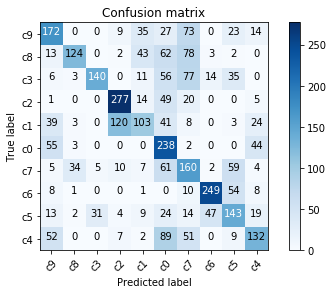

In [21]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
%matplotlib inline

cnf_mat = confusion_matrix(expected_labels, predicted_labels)
plot_confusion_matrix(cnf_mat, v_batches.class_indices)

## Submission

In [22]:
import pandas as pd
def load_array(fname):
    return bcolz.open(fname)[:]
filenames = load_array(filenames_path)
filenames = np.array([f[len('unknown/'):] for f in filenames])

predictions = load_array(predictions_path)
print(predictions[1])
predictions =  np.clip(predictions, 0.01, 0.99)
print(predictions[1])
classes = sorted(val_batches.class_indices, key=val_batches.class_indices.get)
submission = pd.DataFrame(predictions, columns=classes)
submission.insert(0, 'img', filenames)

[ 0.0631  0.0078  0.0149  0.0623  0.1891  0.541   0.0202  0.012   0.027   0.0627]
[ 0.0631  0.01    0.0149  0.0623  0.1891  0.541   0.0202  0.012   0.027   0.0627]


In [23]:
kaggle_submission = results_path+'submission.gz'
submission.to_csv(kaggle_submission, index=False, compression='gzip')

from IPython.display import FileLink

FileLink(kaggle_submission)

/home/sai/Desktop/fast-ai/deeplearning/notebooks/data/statefarm/results/submission.gz